In [1]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data
from algorithms import fixed_bitwidth
from model_gen import inception_cnn
from algorithms.ind_optimized_search import IndependentOptimizedSearch

import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pickle

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
input_shape = (96, 96, 3)
num_outputs = 10 # number of classes
path_trained_weights = 'C:/Users/320060820/experiments/test_models/svhn_df/svhn_df_w.h5'
name = 'svhn_df'

from test_models.svhn_df import data
_, test_data = data.get_data()

model_arch = inception_cnn.InceptionCNN(input_shape, num_outputs, dropout=True,
                                      pool_layer_type='max', path_trained_weights = path_trained_weights)
model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
float_model_acc = model_obj.evaluate_accuracy()[1]
float_model_acc

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


0.921980639213276

### Weights

In [4]:
layer_names = []

for layer in model_obj.model.layers:
    if layer.name.startswith('conv2d') or layer.name.startswith('binary'):
        layer_names.append(layer.name)

In [4]:
# weights
acc_drop_config = {
    layer_name: 0.003 for layer_name in layer_names
}
opts = IndependentOptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc, layer_independent_quant=True)
w_scores, opt_params_weights, acc_drop_w = opts.run('weights', start_bw = 8)
opt_params_weights

{'conv2d_1': [8, 4], 'conv2d_5': [8, 5], 'conv2d_3': [8, 4], 'conv2d_6': [8, 4], 'conv2d_2': [8, 4], 'conv2d_4': [8, 4], 'conv2d_7': [8, 4], 'conv2d_8': [8, 4], 'conv2d_12': [8, 3], 'conv2d_10': [8, 3], 'conv2d_13': [8, 3], 'conv2d_9': [8, 4], 'conv2d_11': [8, 4], 'conv2d_14': [8, 3], 'conv2d_15': [8, 4], 'conv2d_19': [8, 3], 'conv2d_17': [8, 4], 'conv2d_20': [8, 2], 'conv2d_16': [8, 4], 'conv2d_18': [8, 3], 'conv2d_21': [8, 3], 'conv2d_22': [8, 4], 'binary': [8, 6]}
Finding quantization for each layer independently of other layers
Quantizing layer conv2d_1
Global opt: (4, 0) Local opt: (4, 0) Performance diff: 0.000000
Chosen:  (4, 0)
After quantizing layer conv2d_1 | Measured accuracy drop -0.000458 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_5
Global opt: (2, -1) Local opt: (2, -2) Performance diff: 0.000167
Chosen:  (2, -2)
After quantizing layer conv2d_5 | Measured accuracy drop -0.000458 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_3
Global opt: (

{'conv2d_1': (4, 0),
 'conv2d_5': (2, -2),
 'conv2d_3': (3, -1),
 'conv2d_6': (1, -4),
 'conv2d_2': (2, -2),
 'conv2d_4': (3, -1),
 'conv2d_7': (1, -4),
 'conv2d_8': (1, -3),
 'conv2d_12': (4, 0),
 'conv2d_10': (3, -1),
 'conv2d_13': (4, 1),
 'conv2d_9': (2, -2),
 'conv2d_11': (3, -1),
 'conv2d_14': (5, 1),
 'conv2d_15': (1, -3),
 'conv2d_19': (4, 0),
 'conv2d_17': (3, 0),
 'conv2d_20': (4, 0),
 'conv2d_16': (2, -1),
 'conv2d_18': (4, 1),
 'conv2d_21': (6, 1),
 'conv2d_22': (1, -3),
 'binary': (2, 1)}

In [5]:
save_path = 'C:/Users/320060820/experiments/outputs/Independent_Optimized_Search/DF SVHN/'

import pickle

with open(save_path + 'scores_w.p', 'wb') as f:
    pickle.dump(w_scores, f)
with open(save_path + 'opt_params_w.p', 'wb') as f:
    pickle.dump(opt_params_weights, f)
with open(save_path + 'acc_drop_w.p', 'wb') as f:
    pickle.dump(acc_drop_w, f)

Floating point model accuracy: 92.198 %
Quantized model accuracy: 89.567 %
Accuracy drop of 2.854 %


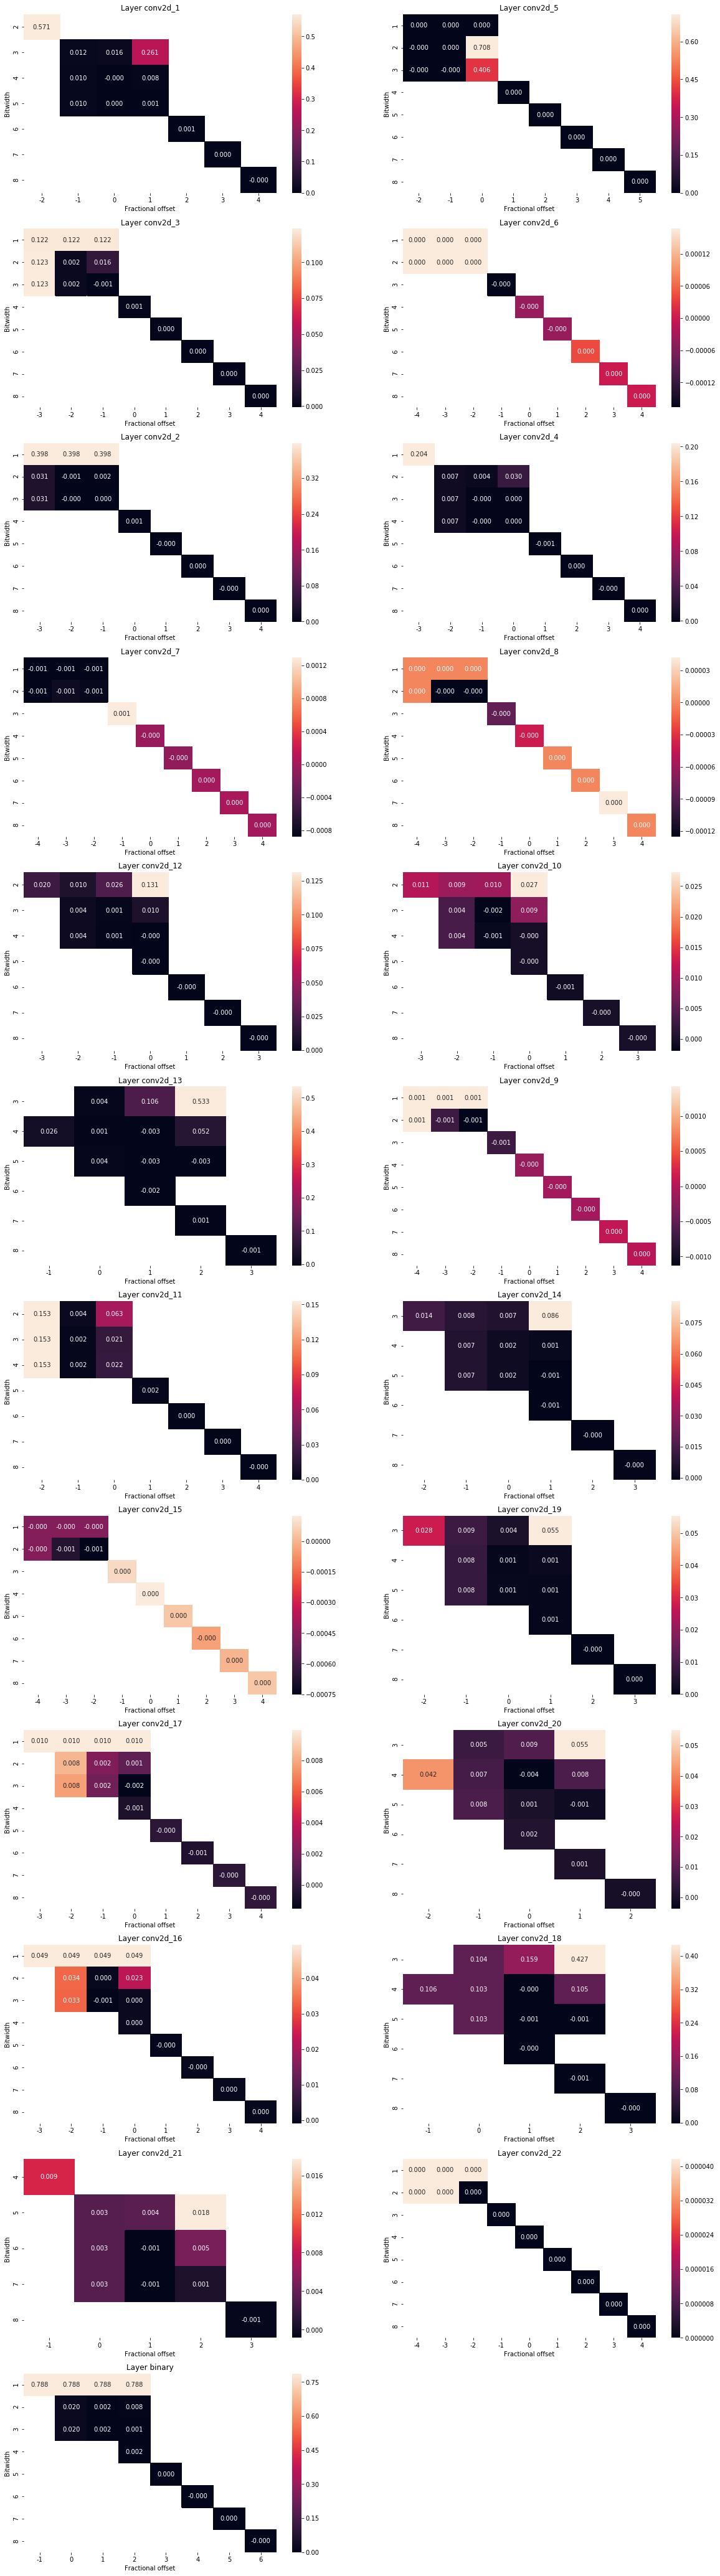

In [6]:
print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
model_obj = fxp_quantize.fix_weights_quantization(model_obj, opt_params_weights)
fxp_model_acc = model_obj.evaluate_accuracy()[1]
print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

opts.plot_scores_matrix(w_scores, 12, 2, (20, 75))

In [7]:
for layer in w_scores:
    print(layer)
    print(f'Layer {layer} acc drop: {w_scores[layer][opt_params_weights[layer][0]][opt_params_weights[layer][1]]:.5f}')

conv2d_1
Layer conv2d_1 acc drop: -0.00046
conv2d_5
Layer conv2d_5 acc drop: -0.00008
conv2d_3
Layer conv2d_3 acc drop: -0.00092
conv2d_6
Layer conv2d_6 acc drop: 0.00017
conv2d_2
Layer conv2d_2 acc drop: -0.00100
conv2d_4
Layer conv2d_4 acc drop: -0.00029
conv2d_7
Layer conv2d_7 acc drop: -0.00087
conv2d_8
Layer conv2d_8 acc drop: 0.00000
conv2d_12
Layer conv2d_12 acc drop: -0.00025
conv2d_10
Layer conv2d_10 acc drop: -0.00196
conv2d_13
Layer conv2d_13 acc drop: -0.00296
conv2d_9
Layer conv2d_9 acc drop: -0.00112
conv2d_11
Layer conv2d_11 acc drop: 0.00200
conv2d_14
Layer conv2d_14 acc drop: -0.00100
conv2d_15
Layer conv2d_15 acc drop: -0.00046
conv2d_19
Layer conv2d_19 acc drop: 0.00071
conv2d_17
Layer conv2d_17 acc drop: -0.00154
conv2d_20
Layer conv2d_20 acc drop: -0.00375
conv2d_16
Layer conv2d_16 acc drop: 0.00012
conv2d_18
Layer conv2d_18 acc drop: -0.00050
conv2d_21
Layer conv2d_21 acc drop: -0.00083
conv2d_22
Layer conv2d_22 acc drop: 0.00004
binary
Layer binary acc drop: 0.00

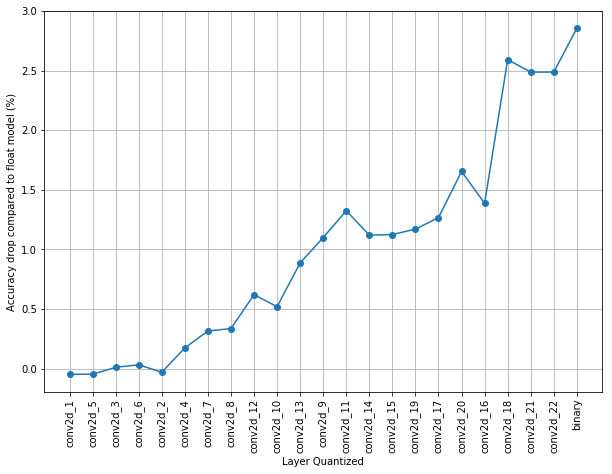

In [8]:
x = np.arange(1, len(acc_drop_w.values()) + 1, 1)
y = np.array(list(acc_drop_w.values())) * 100
labels = list(opt_params_weights.keys())

plt.figure(figsize=(10, 7))
plt.plot(x, y, 'o-');
plt.xlabel('Layer Quantized')
plt.ylabel('Accuracy drop compared to float model (%)')
plt.xticks(x, labels, rotation='vertical');
plt.grid()

## Biases

In [5]:
# biases
acc_drop_config = {
    layer_name: 0.003 for layer_name in layer_names
}
opts = IndependentOptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc, layer_independent_quant=True)
b_scores, opt_params_biases, acc_drop_b = opts.run('biases', start_bw = 8)
opt_params_biases

{'conv2d_1': [8, 6], 'conv2d_5': [8, 5], 'conv2d_3': [8, 4], 'conv2d_6': [8, 5], 'conv2d_2': [8, 4], 'conv2d_4': [8, 4], 'conv2d_7': [8, 6], 'conv2d_8': [8, 5], 'conv2d_12': [8, 3], 'conv2d_10': [8, 5], 'conv2d_13': [8, 5], 'conv2d_9': [8, 5], 'conv2d_11': [8, 5], 'conv2d_14': [8, 4], 'conv2d_15': [8, 4], 'conv2d_19': [8, 4], 'conv2d_17': [8, 4], 'conv2d_20': [8, 5], 'conv2d_16': [8, 4], 'conv2d_18': [8, 4], 'conv2d_21': [8, 3], 'conv2d_22': [8, 5], 'binary': [8, 6]}
Finding quantization for each layer independently of other layers
Quantizing layer conv2d_1
Global opt: (1, -1) Local opt: (2, 0) Performance diff: 0.003667
Chosen:  (2, 0)
After quantizing layer conv2d_1 | Measured accuracy drop -0.001208 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_5
Global opt: (1, -2) Local opt: (1, -3) Performance diff: 0.000000
Chosen:  (1, -3)
After quantizing layer conv2d_5 | Measured accuracy drop -0.001125 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_3
Global opt: 

{'conv2d_1': (2, 0),
 'conv2d_5': (1, -3),
 'conv2d_3': (1, -3),
 'conv2d_6': (1, -3),
 'conv2d_2': (1, -3),
 'conv2d_4': (1, -3),
 'conv2d_7': (1, -2),
 'conv2d_8': (1, -3),
 'conv2d_12': (1, -4),
 'conv2d_10': (1, -2),
 'conv2d_13': (1, -2),
 'conv2d_9': (1, -2),
 'conv2d_11': (1, -3),
 'conv2d_14': (1, -4),
 'conv2d_15': (1, -4),
 'conv2d_19': (1, -4),
 'conv2d_17': (1, -3),
 'conv2d_20': (1, -2),
 'conv2d_16': (1, -3),
 'conv2d_18': (1, -3),
 'conv2d_21': (1, -4),
 'conv2d_22': (1, -3),
 'binary': (2, 0)}

Floating point model accuracy: 92.198 %
Quantized model accuracy: 92.152 %
Accuracy drop of 0.050 %


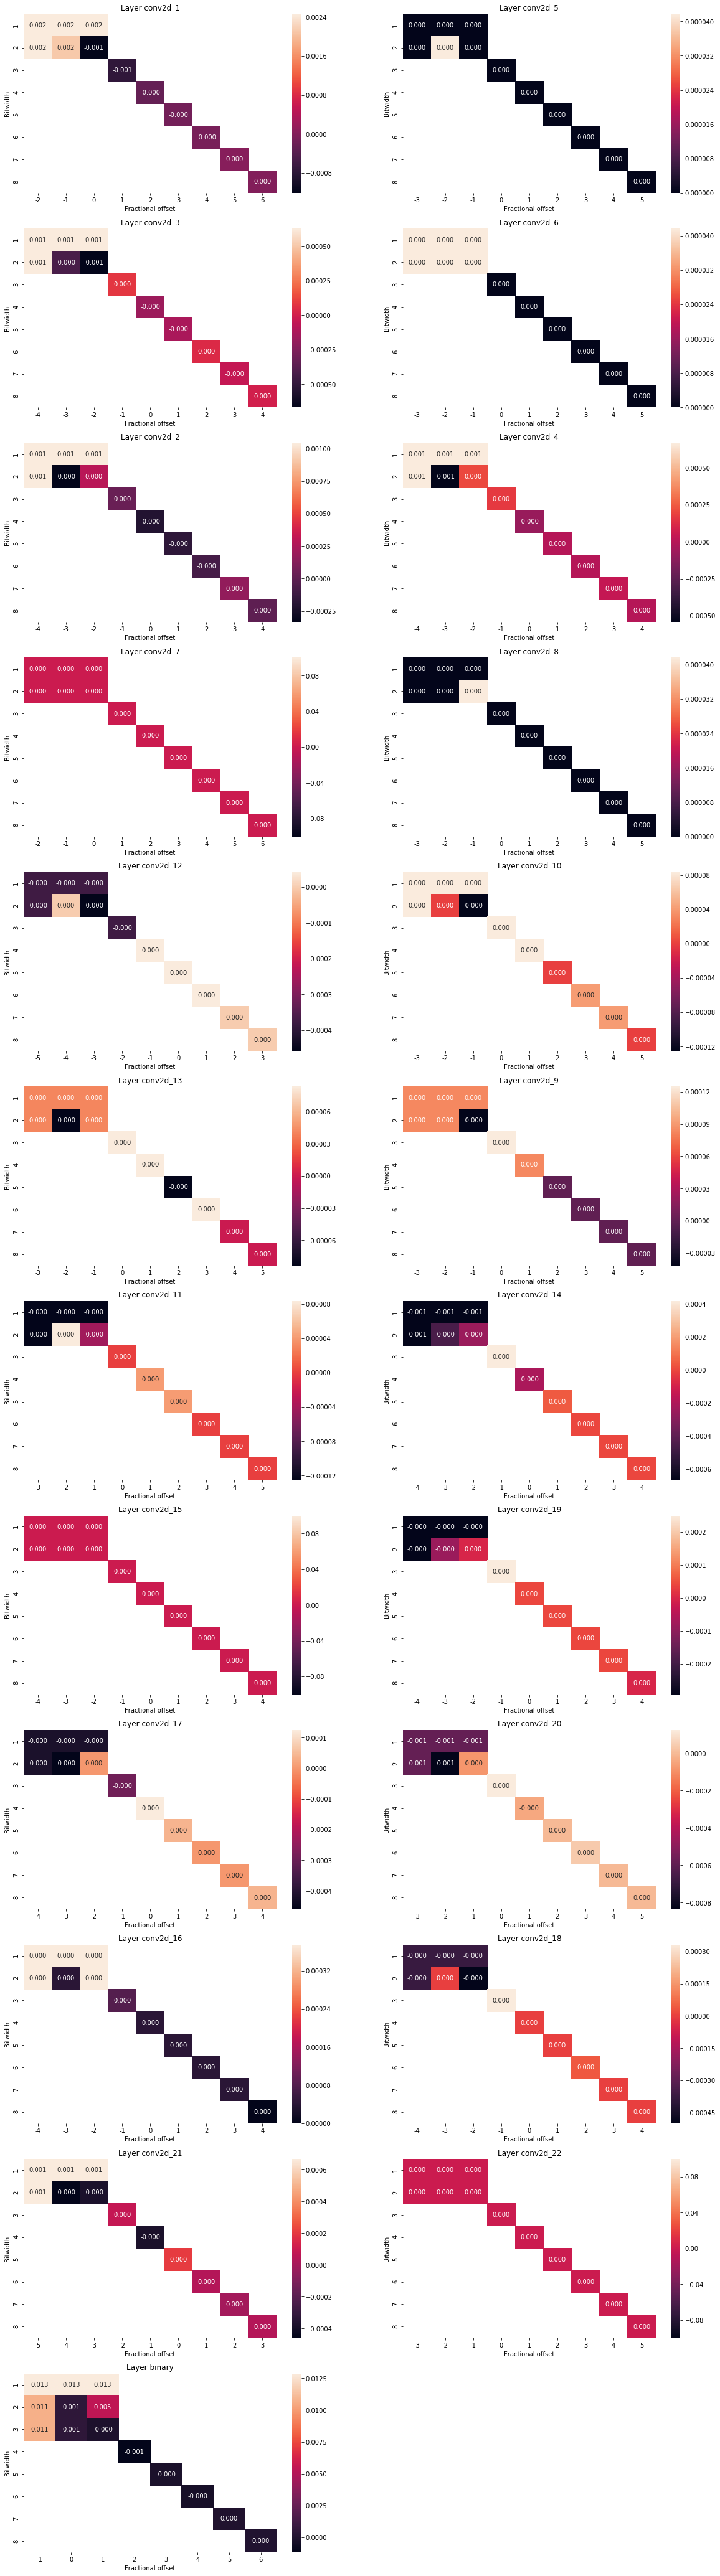

In [6]:
print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

model_obj = model_data.Model(name, test_data, model=model_arch.get_float_model())
model_obj = fxp_quantize.fix_biases_quantization(model_obj, opt_params_biases)
fxp_model_acc = model_obj.evaluate_accuracy()[1]
print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

opts.plot_scores_matrix(b_scores, 12, 2, (20, 75))

In [7]:
for layer in b_scores:
    print(f'Layer {layer} acc drop: {b_scores[layer][opt_params_biases[layer][0]][opt_params_biases[layer][1]]:.5f}')

Layer conv2d_1 acc drop: -0.00121
Layer conv2d_5 acc drop: 0.00000
Layer conv2d_3 acc drop: 0.00062
Layer conv2d_6 acc drop: 0.00004
Layer conv2d_2 acc drop: 0.00104
Layer conv2d_4 acc drop: 0.00067
Layer conv2d_7 acc drop: 0.00000
Layer conv2d_8 acc drop: 0.00000
Layer conv2d_12 acc drop: -0.00037
Layer conv2d_10 acc drop: 0.00008
Layer conv2d_13 acc drop: 0.00004
Layer conv2d_9 acc drop: 0.00008
Layer conv2d_11 acc drop: -0.00012
Layer conv2d_14 acc drop: -0.00067
Layer conv2d_15 acc drop: 0.00000
Layer conv2d_19 acc drop: -0.00029
Layer conv2d_17 acc drop: -0.00042
Layer conv2d_20 acc drop: -0.00058
Layer conv2d_16 acc drop: 0.00037
Layer conv2d_18 acc drop: -0.00037
Layer conv2d_21 acc drop: 0.00067
Layer conv2d_22 acc drop: 0.00000
Layer binary acc drop: 0.00058


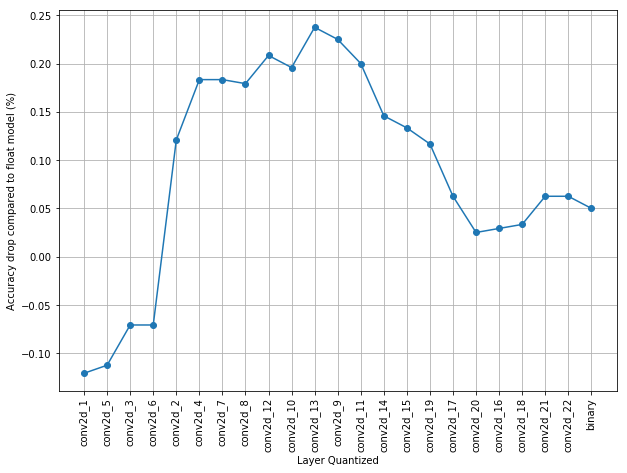

In [8]:
x = np.arange(1, len(acc_drop_b.values()) + 1, 1)
y = np.array(list(acc_drop_b.values())) * 100
labels = list(acc_drop_b.keys())

plt.figure(figsize=(10, 7))
plt.plot(x, y, 'o-');
plt.xlabel('Layer Quantized')
plt.ylabel('Accuracy drop compared to float model (%)')
plt.xticks(x, labels, rotation='vertical');
plt.grid()

### Activations

In [9]:
acc_drop_config = {
    layer_name: 0.003 for layer_name in layer_names
}
opts = IndependentOptimizedSearch(acc_drop_config, model_arch, name, test_data, float_model_acc, layer_independent_quant=True)
a_scores, opt_params_act, acc_drop_a = opts.run('activations', start_bw = 10)
opt_params_act

{'conv2d_1': [10, 3], 'conv2d_5': [10, 3], 'conv2d_3': [10, 2], 'conv2d_6': [10, 0], 'conv2d_2': [10, 2], 'conv2d_4': [10, -2], 'conv2d_7': [10, 0], 'conv2d_8': [10, 2], 'conv2d_12': [10, 0], 'conv2d_10': [10, -1], 'conv2d_13': [10, -1], 'conv2d_9': [10, -1], 'conv2d_11': [10, -2], 'conv2d_14': [10, -1], 'conv2d_15': [10, 0], 'conv2d_19': [10, 0], 'conv2d_17': [10, 0], 'conv2d_20': [10, -2], 'conv2d_16': [10, 0], 'conv2d_18': [10, -2], 'conv2d_21': [10, -2], 'conv2d_22': [10, 1], 'binary': [10, 4]}
Finding quantization for each layer independently of other layers
Quantizing layer conv2d_1
Global opt: (8, 3) Local opt: (9, 3) Performance diff: 0.000958
Chosen:  (8, 3)
After quantizing layer conv2d_1 | Measured accuracy drop 0.000792 | Acceptable accuracy drop: 0.003000
Quantizing layer conv2d_5
Global opt: (1, -6) Local opt: (2, -5) Performance diff: 0.000167
Chosen:  (1, -6)
After quantizing layer conv2d_5 | Measured accuracy drop 0.001042 | Acceptable accuracy drop: 0.003000
Quantizin

{'conv2d_1': (8, 3),
 'conv2d_5': (1, -6),
 'conv2d_3': (5, -1),
 'conv2d_6': (1, -9),
 'conv2d_2': (5, -3),
 'conv2d_4': (5, -5),
 'conv2d_7': (1, -10),
 'conv2d_8': (1, -7),
 'conv2d_12': (5, -4),
 'conv2d_10': (4, -4),
 'conv2d_13': (6, -4),
 'conv2d_9': (1, -11),
 'conv2d_11': (3, -7),
 'conv2d_14': (5, -5),
 'conv2d_15': (1, -9),
 'conv2d_19': (4, -5),
 'conv2d_17': (4, -4),
 'conv2d_20': (5, -5),
 'conv2d_16': (2, -7),
 'conv2d_18': (3, -8),
 'conv2d_21': (6, -5),
 'conv2d_22': (1, -9),
 'binary': (5, 0)}

In [10]:
with open(save_path + 'scores_a.p', 'wb') as f:
    pickle.dump(a_scores, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(save_path + 'opt_params_a.p', 'wb') as f:
    pickle.dump(opt_params_act, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(save_path + 'acc_drop_a.p', 'wb') as f:
    pickle.dump(acc_drop_a, f, protocol=pickle.HIGHEST_PROTOCOL)

Floating point model accuracy: 92.198 %
Quantized model accuracy: 90.055 %
Accuracy drop of 2.325 %


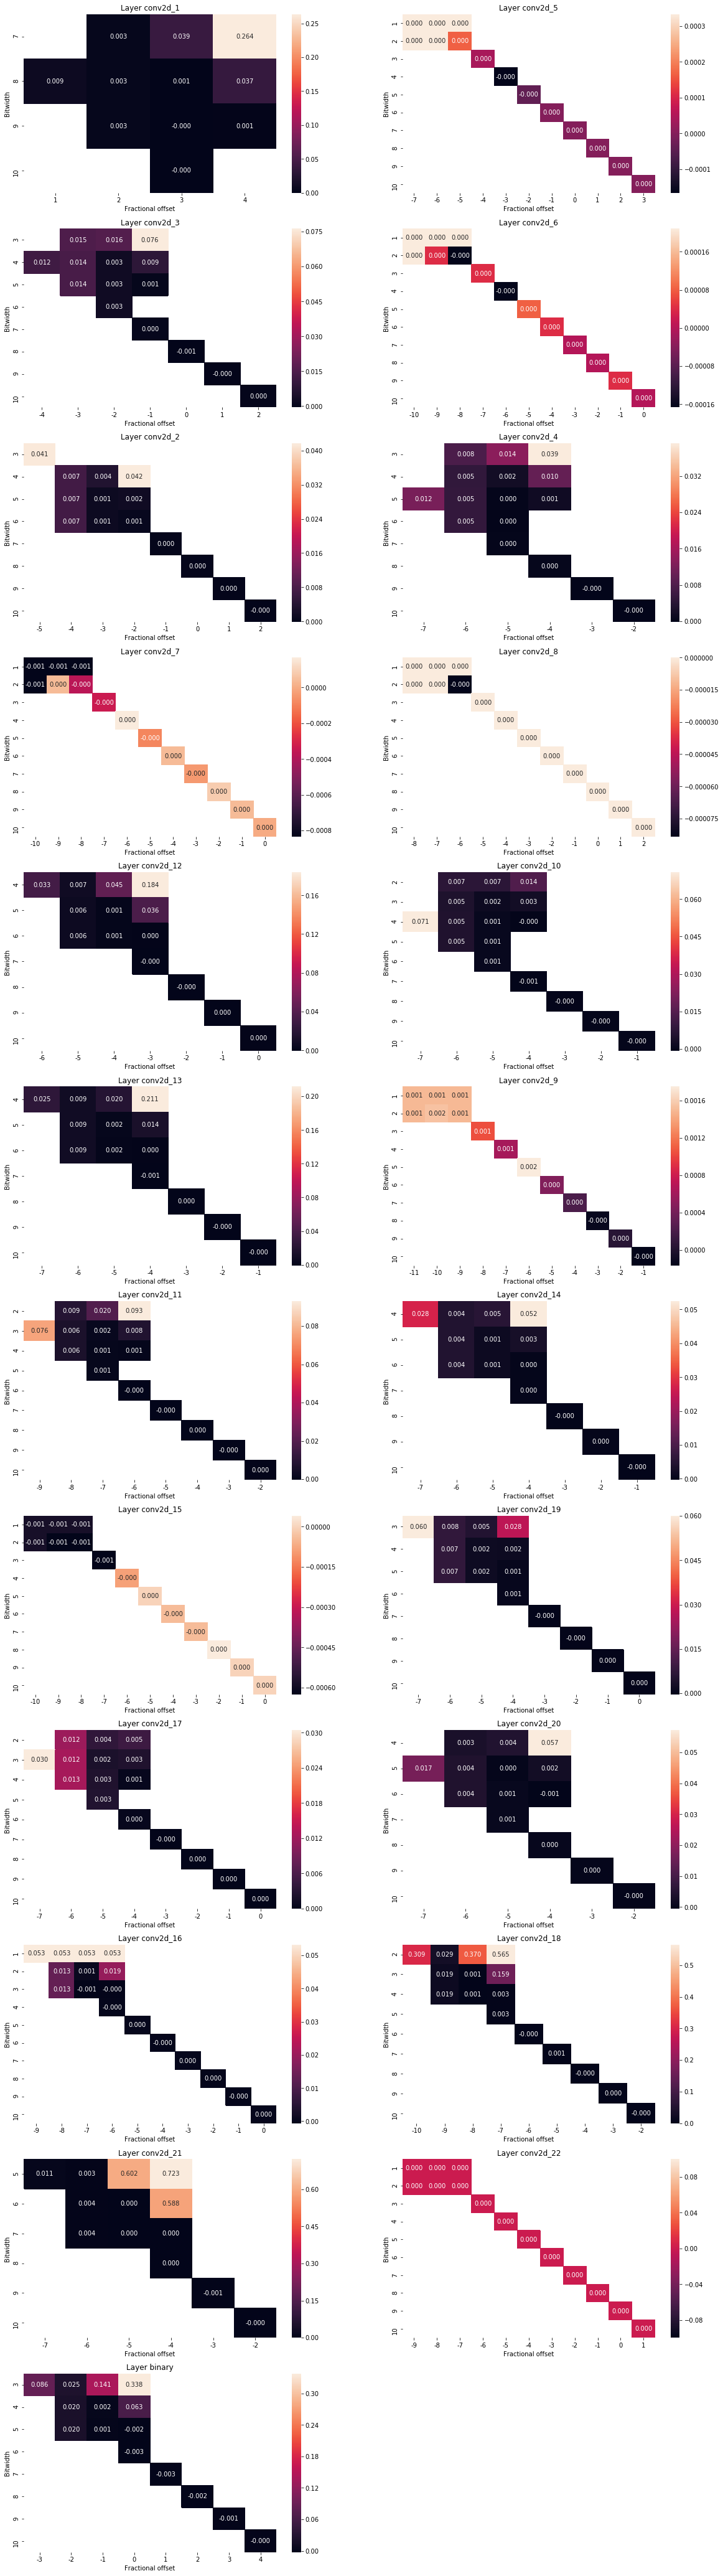

In [11]:
print(f'Floating point model accuracy: {float_model_acc * 100 :.3f} %')

model_obj = model_data.Model(name, test_data, model=model_arch.get_fxp_model(opt_params_act))
fxp_model_acc = model_obj.evaluate_accuracy()[1]
print(f'Quantized model accuracy: {fxp_model_acc * 100 :.3f} %')
print(f'Accuracy drop of {(float_model_acc - fxp_model_acc) / float_model_acc * 100 :.3f} %')

opts.plot_scores_matrix(a_scores, 12, 2, (20, 75))

In [9]:
import pickle
save_path = 'C:/Users/320060820/experiments/outputs/Independent_Optimized_Search/DF SVHN/'

In [10]:
with open(save_path + 'opt_params_w.p', 'rb') as f:
    opt_params_weights = pickle.load(f)
with open(save_path + 'opt_params_a.p', 'rb') as f:
    opt_params_act = pickle.load(f)

In [11]:
def quantize_evaluate(model_arch, test_data, float_model_acc, w_quant_params, b_quant_params={}, a_quant_params={}):
    
    if a_quant_params:
        model_obj = model_data.Model('name', test_data, model=model_arch.get_fxp_model(a_quant_params))
    else:
        model_obj = model_data.Model('name', test_data, model=model_arch.get_float_model())
    
    model_obj = fxp_quantize.fix_weights_quantization(model_obj, w_quant_params)
    if b_quant_params:
        model_obj = fxp_quantize.fix_biases_quantization(model_obj, b_quant_params)
    
    return (float_model_acc - model_obj.evaluate_accuracy()[1]) / float_model_acc

def evaluate_seq_quant_performance(model_arch, test_data, float_model_acc, w_quant_params, b_quant_params, a_quant_params):
    
    acc_drop_b = {}
    for i in range(1, len(list(b_quant_params.keys())) + 1):
        test_case = dict(itertools.islice(b_quant_params.items(), i))
        a = quantize_evaluate(model_arch, test_data, float_model_acc, w_quant_params, test_case)
        acc_drop_b[list(test_case.keys())[-1]] = a
        print(acc_drop_b)

    acc_drop_a = {}
    for i in range(1, len(list(a_quant_params.keys())) + 1):
        test_case = dict(itertools.islice(a_quant_params.items(), i))
        a = quantize_evaluate(model_arch, test_data, float_model_acc, w_quant_params, b_quant_params, test_case)
        acc_drop_a[list(test_case.keys())[-1]] = a
        print(acc_drop_a)
        
    return acc_drop_b, acc_drop_a  

In [12]:
acc_drop_b, acc_drop_a = evaluate_seq_quant_performance(model_arch, test_data, float_model_acc, opt_params_weights, 
                                            opt_params_biases,
                                            opt_params_act)

{'conv2d_1': 0.028082163243198253}
{'conv2d_1': 0.028082163243198253, 'conv2d_5': 0.028082163243198253}
{'conv2d_1': 0.028082163243198253, 'conv2d_5': 0.028082163243198253, 'conv2d_3': 0.03237365109787091}
{'conv2d_1': 0.028082163243198253, 'conv2d_5': 0.028082163243198253, 'conv2d_3': 0.03237365109787091, 'conv2d_6': 0.03237365109787091}
{'conv2d_1': 0.028082163243198253, 'conv2d_5': 0.028082163243198253, 'conv2d_3': 0.03237365109787091, 'conv2d_6': 0.03237365109787091, 'conv2d_2': 0.03212366151410365}
{'conv2d_1': 0.028082163243198253, 'conv2d_5': 0.028082163243198253, 'conv2d_3': 0.03237365109787091, 'conv2d_6': 0.03237365109787091, 'conv2d_2': 0.03212366151410365, 'conv2d_4': 0.032956960126661404}
{'conv2d_1': 0.028082163243198253, 'conv2d_5': 0.028082163243198253, 'conv2d_3': 0.03237365109787091, 'conv2d_6': 0.03237365109787091, 'conv2d_2': 0.03212366151410365, 'conv2d_4': 0.032956960126661404, 'conv2d_7': 0.03291529519603358}
{'conv2d_1': 0.028082163243198253, 'conv2d_5': 0.02808

{'conv2d_1': 0.028082163243198253, 'conv2d_5': 0.028082163243198253, 'conv2d_3': 0.03237365109787091, 'conv2d_6': 0.03237365109787091, 'conv2d_2': 0.03212366151410365, 'conv2d_4': 0.032956960126661404, 'conv2d_7': 0.03291529519603358, 'conv2d_8': 0.032956960126661404, 'conv2d_12': 0.034248572976126074, 'conv2d_10': 0.03412357818424239, 'conv2d_13': 0.03470688721303288, 'conv2d_9': 0.035040206658056, 'conv2d_11': 0.03508187158868382, 'conv2d_14': 0.03708178825882255, 'conv2d_15': 0.037165118120078305, 'conv2d_19': 0.03741510770384567, 'conv2d_17': 0.040081663264030655, 'conv2d_20': 0.03991500354151915, 'conv2d_16': 0.0398316736802634, 'conv2d_18': 0.040248322986542275, 'conv2d_21': 0.038748385483938164, 'conv2d_22': 0.038748385483938164, 'binary': 0.04003999833340284}
{'conv2d_1': 0.04474813549435448}
{'conv2d_1': 0.04474813549435448, 'conv2d_5': 0.04474813549435448}
{'conv2d_1': 0.04474813549435448, 'conv2d_5': 0.04474813549435448, 'conv2d_3': 0.04366484729802925}
{'conv2d_1': 0.044748

{'conv2d_1': 0.04474813549435448, 'conv2d_5': 0.04474813549435448, 'conv2d_3': 0.04366484729802925, 'conv2d_6': 0.04366484729802925, 'conv2d_2': 0.04620640806633066, 'conv2d_4': 0.046081413274446974, 'conv2d_7': 0.046081413274446974, 'conv2d_8': 0.046081413274446974, 'conv2d_12': 0.04728969626265577, 'conv2d_10': 0.0488312986958877, 'conv2d_13': 0.04824798966709721, 'conv2d_9': 0.04920628307153876, 'conv2d_11': 0.0548310487063039, 'conv2d_14': 0.05633098620890801, 'conv2d_15': 0.05633098620890801, 'conv2d_19': 0.05795591850339568, 'conv2d_17': 0.05770592891962843, 'conv2d_20': 0.06041414941044122, 'conv2d_16': 0.05453939419190871, 'conv2d_18': 0.08707970501229124, 'conv2d_21': 0.08841298279238373, 'conv2d_22': 0.08841298279238373}
{'conv2d_1': 0.04474813549435448, 'conv2d_5': 0.04474813549435448, 'conv2d_3': 0.04366484729802925, 'conv2d_6': 0.04366484729802925, 'conv2d_2': 0.04620640806633066, 'conv2d_4': 0.046081413274446974, 'conv2d_7': 0.046081413274446974, 'conv2d_8': 0.04608141327

In [13]:
with open(save_path + 'scores_b.p', 'wb') as f:
    pickle.dump(b_scores, f)
with open(save_path + 'opt_params_b.p', 'wb') as f:
    pickle.dump(opt_params_biases, f)
with open(save_path + 'acc_drop_b.p', 'wb') as f:
    pickle.dump(acc_drop_b, f)

with open(save_path + 'acc_drop_a.p', 'wb') as f:
    pickle.dump(acc_drop_a, f)